<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scale" data-toc-modified-id="Scale-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scale</a></span><ul class="toc-item"><li><span><a href="#Many-roads-to-Rome..." data-toc-modified-id="Many-roads-to-Rome...-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Many roads to Rome...</a></span></li><li><span><a href="#Unlike-SkLearn..." data-toc-modified-id="Unlike-SkLearn...-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Unlike SkLearn...</a></span></li></ul></li><li><span><a href="#Fit" data-toc-modified-id="Fit-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fit</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#class_weight:" data-toc-modified-id="class_weight:-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>class_weight:</a></span></li><li><span><a href="#validation_split:" data-toc-modified-id="validation_split:-2.0.0.2"><span class="toc-item-num">2.0.0.2&nbsp;&nbsp;</span>validation_split:</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Model-validation-on-Test" data-toc-modified-id="Model-validation-on-Test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model validation on Test</a></span></li><li><span><a href="#Predict" data-toc-modified-id="Predict-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict</a></span></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build the model</a></span></li></ul></div>

https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb



Hyperparameter   |   Typical value
:--- |:--- |
No. Input Neurons | 1 per input feature (e.g. 28 x28 = 784 for MNST 
No. hidden layers | Depends on problem, typically 1 to 5</td>
No. Neurons per hidden layers | Depend on the (complexity of) the problem, typically 10 to 100
No. output neurons | 1 per prediction dimension
Hidden Activation |Positive outputs: None or ReLU/Softplus/max. <br> Bounded outputs Sigmoid or Tanh
Loss Function | MSE or MAE/Huber(in case of outliers)

Hyperparameter | Binary <br> Classification | Multi label binary <br> classification | Multi class <br> classification
---|---|---|--- |
Example | Spam: y/n | Spam: y/n *and* Urgent: y/n | choice of 1 classes
No. output neurons | 1 | 1 per label | 1 per class
Output layer activation | Logistic/sigmoid | Logistic/sigmoid | Logistic/sigmoid
Loss Function | Cross-entropy/<br>Log Loss | Cross-entropy/<br>Log Loss | Cross-entropy/<br>Log Loss


In [58]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

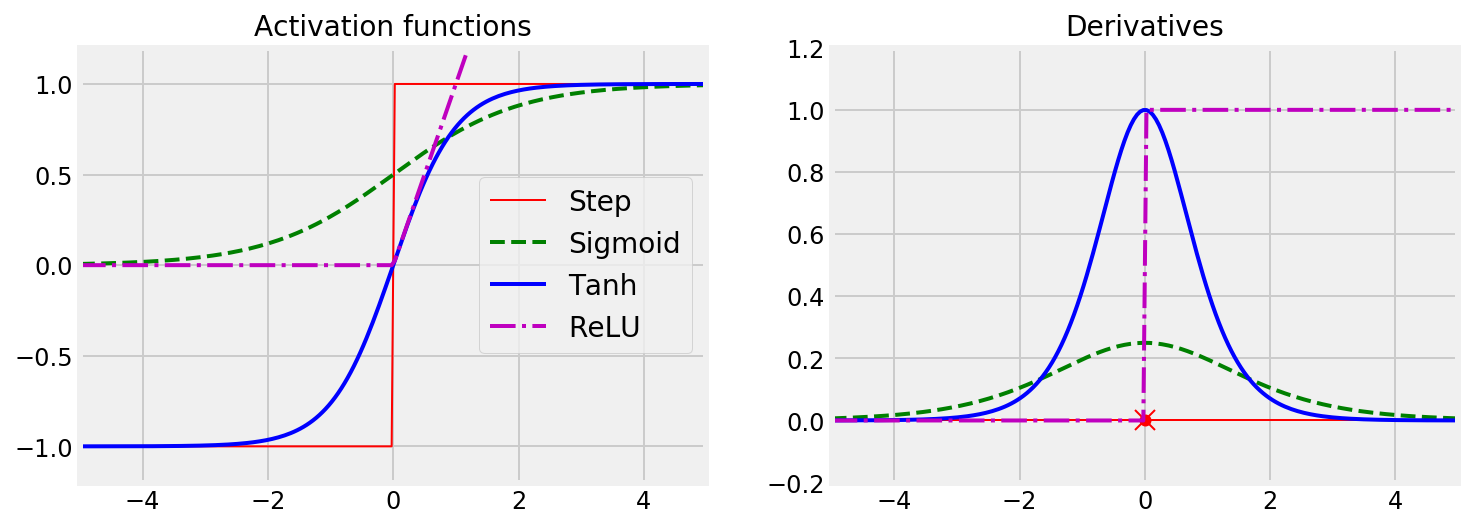

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("activation_functions_plot")
plt.show()

In [4]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

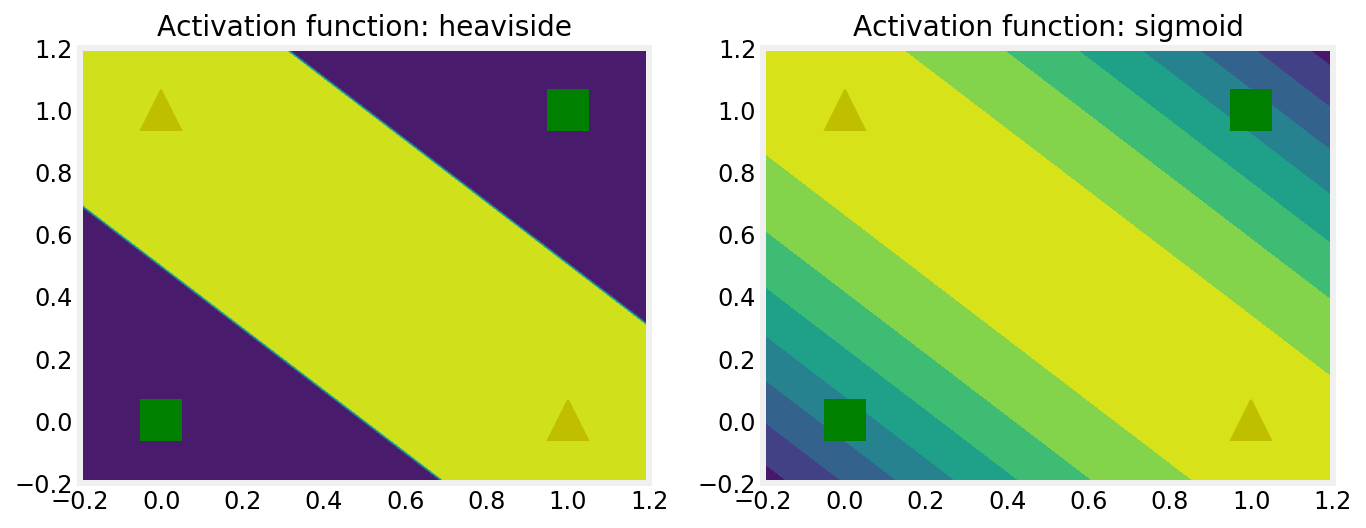

In [5]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)


In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.0.0'

In [160]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [161]:
X_train_full.shape

(60000, 28, 28)

In [162]:
X_train_full.dtype

dtype('uint8')

Unscaled data

In [163]:
X_train_full[1][:1]

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=uint8)

## Scale

In some rare cases scaling may not be required. However in a majority of the cases it **is**.
All sklearn scaling techniques are fine (sometime 0-1 scaling may be specifically required)

Below will work just as well:
> "Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255."

Validation sets may be define specifically, but it is also possible at the time of fitting the model

In [164]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

scaled data

In [165]:
X_train[1][:1]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.17254902, 0.21568627, 0.37647059,
        0.78823529, 0.1372549 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.23529412, 0.72156863, 0.20784314,
        0.19607843, 0.06666667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

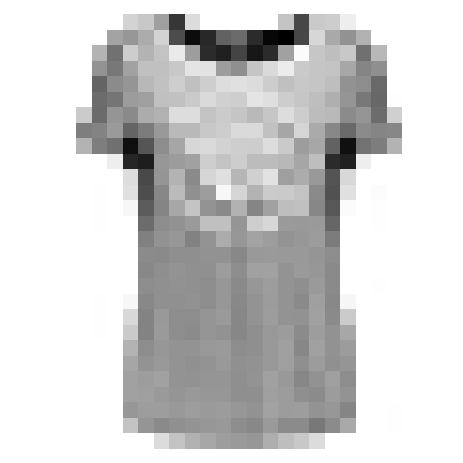

In [166]:
plt.imshow(X_train[1], cmap="binary")
plt.axis('off')
plt.show()

In [167]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [168]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Saving figure fashion_mnist_plot


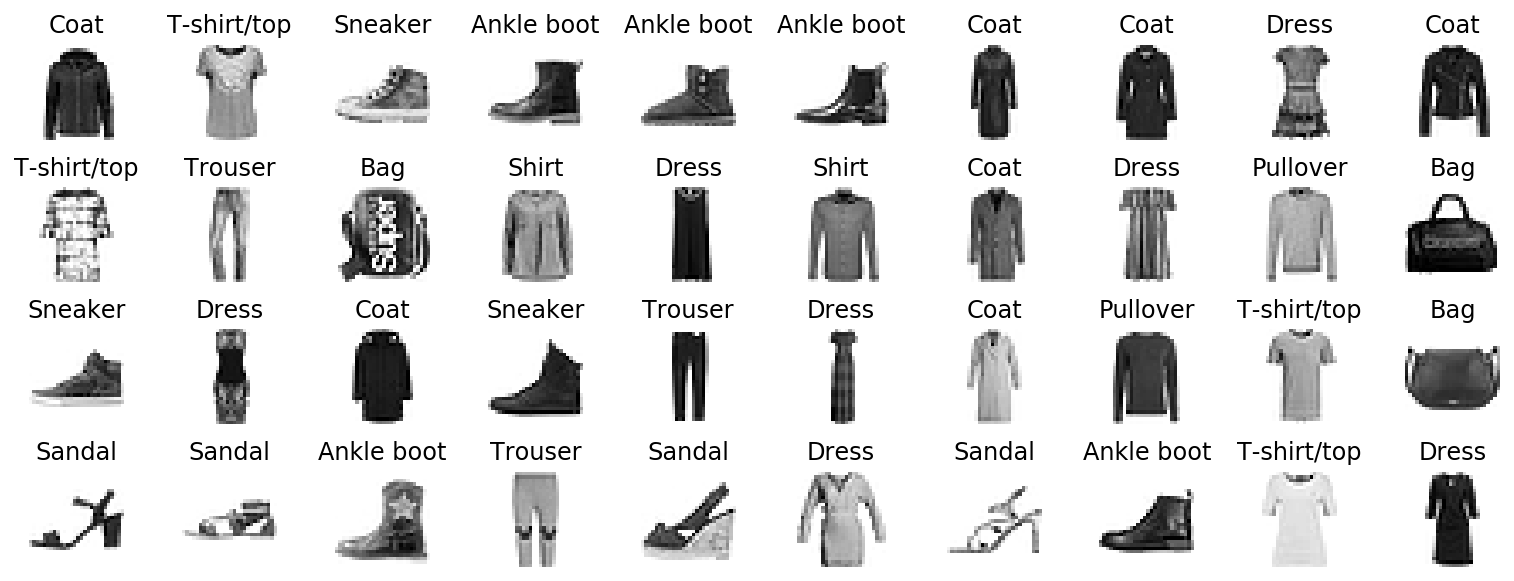

In [169]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [177]:
# Perfectly balanced
pd.Series(y_train_full).value_counts()#plot(kind='hist')

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

# Creating an ANN

The elegance of Keras is that you actually build the model by specifying the layers, inputs, outputs, connections, activation etc. It is *declarative*

Note: there is no data yet, just stating the network what to expect and what to do

In [170]:
#instanciate the model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # equal to X.reshape(-1,1)
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))


Since it is an object, it has some nifty functions

In [178]:
model.layers

In [179]:
#In words
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


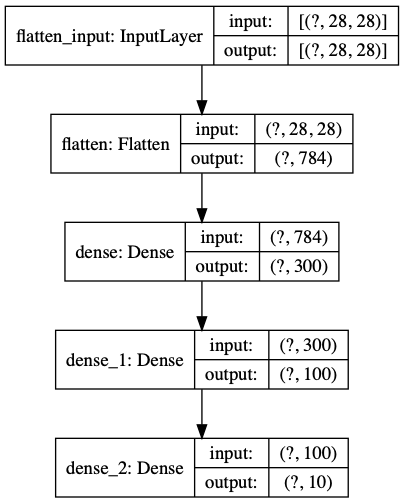

In [29]:
#In a picture
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

### Many roads to Rome...

Slightly different instantiations will work as well

In [77]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

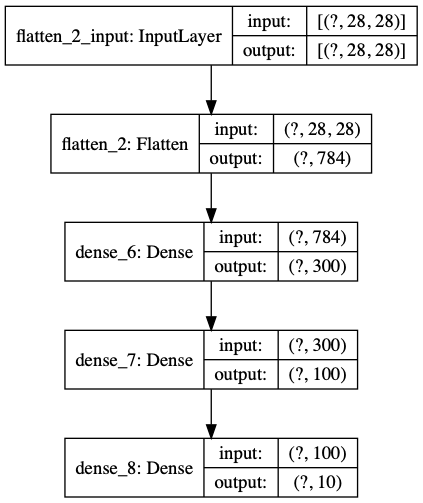

In [78]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [80]:
weights, biases = model.layers[1].get_weights()
biases[:6]

array([0., 0., 0., 0., 0., 0.], dtype=float32)

### Unlike SkLearn...

For loads of reasons Keras/tf does not 'reset' or overwrite an instantiated model object. It adds to it. The back-end needs to be actively reset.

In [81]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu", bias_initializer='RandomNormal', name = 'Maarten1'),#illustration
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [91]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Maarten1 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [84]:
weights, biases = model.layers[1].get_weights()

In [85]:
weights[0][:6]

array([ 0.02448617, -0.00877795, -0.02189048, -0.00528485, -0.06938942,
        0.02747849], dtype=float32)

In [86]:
weights.shape

(784, 300)

In [87]:
#effect of RandonNormal
biases[:6]

array([ 0.00421123, -0.04304519,  0.01890615, -0.00025981, -0.0247266 ,
        0.03089096], dtype=float32)

In [88]:
biases.shape

(300,)

In [95]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy", "sparse_categorical_accuracy" ])

Loss | classification problem | target vectors
--- | --- | ---
sparse_categorical_crossentropy | sparse labels, exclusive classes (probs add up to 1) | 1 each class own value
categorical_crossentropy | one-hot binary vectors for each class | each class own vector
binary cross entropy | 1 or many binary targets (**Use Softamx**) | 1 per target

In [93]:
# Many roads to rome
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

## Fit

Handy features from the doc string:  
##### class_weight:   
Optional dictionary mapping class indices (integers)
        to a weight (float) value, used for weighting the loss function
        (during training only).
        This can be useful to tell the model to
        "pay more attention" to samples from
        an under-represented class.
##### validation_split:   
Float between 0 and 1.
        Fraction of the training data to be used as validation data.
        The model will set apart this fraction of the training data,
        will not train on it, and will evaluate
        the loss and any model metrics
        on this data at the end of each epoch.
        The validation data is selected from the last samples
        in the `x` and `y` data provided, before shuffling. This argument is
        not supported when `x` is a dataset, generator or
       `keras.utils.Sequence` instance.

In [96]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 5s 91us/sample - loss: 0.7101 - accuracy: 0.7660 - sparse_categorical_accuracy: 0.7660 - val_loss: 0.5276 - val_accuracy: 0.8162 - val_sparse_categorical_accuracy: 0.8162
Epoch 2/30
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4860 - accuracy: 0.8309 - sparse_categorical_accuracy: 0.8309 - val_loss: 0.4496 - val_accuracy: 0.8460 - val_sparse_categorical_accuracy: 0.8460
Epoch 3/30
55000/55000 [==============================] - 5s 88us/sample - loss: 0.4407 - accuracy: 0.8458 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.4171 - val_accuracy: 0.8578 - val_sparse_categorical_accuracy: 0.8578
Epoch 4/30
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4155 - accuracy: 0.8542 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.3868 - val_accuracy: 0.8684 - val_sparse_categorical_accuracy: 0.8684
Epoch 5/30
55000/55000 [===========

In [97]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss',
  'accuracy',
  'sparse_categorical_accuracy',
  'val_loss',
  'val_accuracy',
  'val_sparse_categorical_accuracy']}

In [98]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'sparse_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_sparse_categorical_accuracy'])

In [100]:
pd.DataFrame(history.history).head()

,loss,accuracy,sparse_categorical_accuracy,val_loss,val_accuracy,val_sparse_categorical_accuracy
0,0.710135,0.765964,0.765964,0.527619,0.8162,0.8162
1,0.486025,0.830891,0.830891,0.449608,0.8460,0.8460
2,0.440702,0.845782,0.845782,0.417078,0.8578,0.8578
3,0.415505,0.854200,0.854200,0.386796,0.8684,0.8684
4,0.395487,0.860764,0.860764,0.399148,0.8590,0.8590


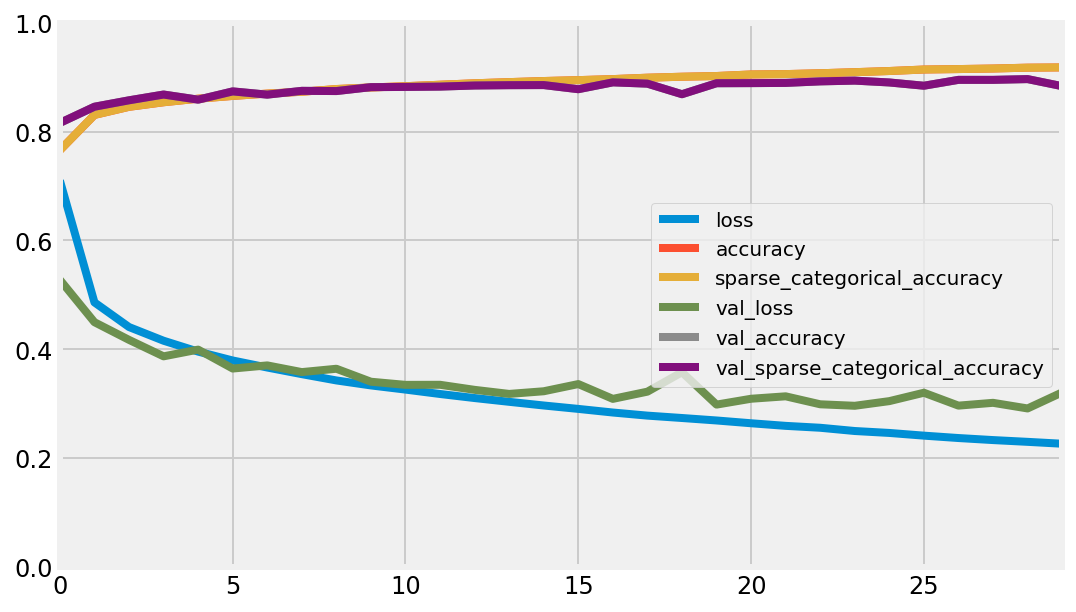

In [99]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

## Model validation on Test

In [101]:
model.evaluate(X_test, y_test, verbose = 0)

[56.56036575046042, 0.8549, 0.8549]

## Predict

In [106]:
#create some new data
X_new = X_test[:3]

y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [107]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [108]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [109]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

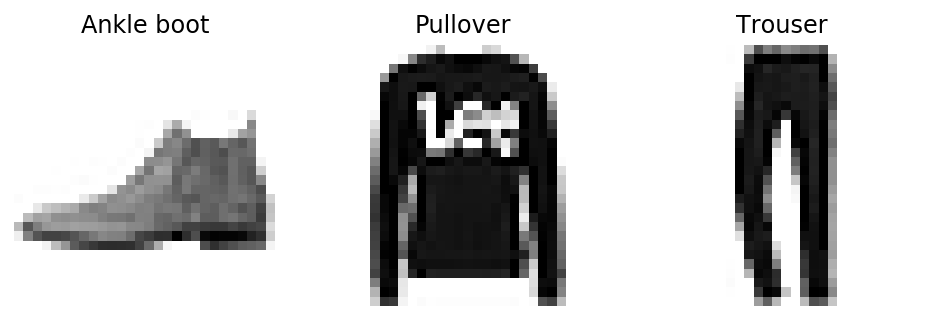

In [110]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

In [188]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [189]:
df = pd.DataFrame(housing['data'],
                      columns=housing['feature_names'])
df['ycol'] = housing['target']

In [190]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,ycol
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


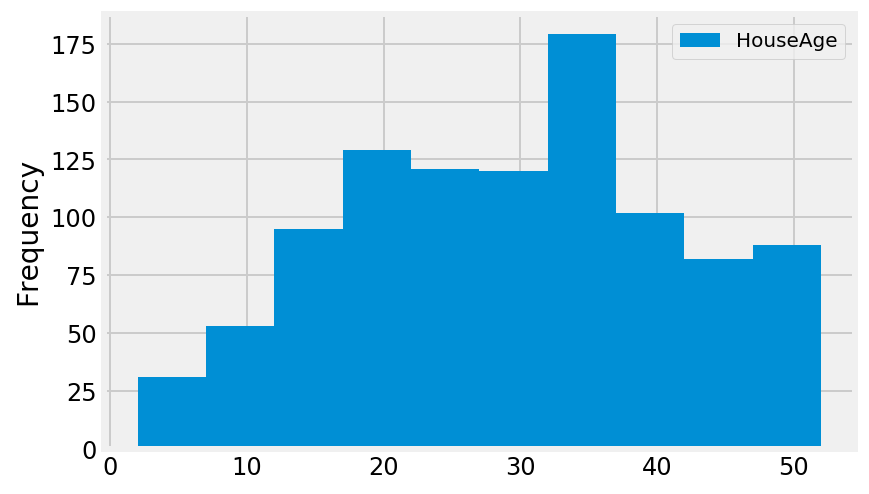

In [191]:
df[['HouseAge']].sample(1000).plot(kind='hist')

In [192]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [193]:
X_train.shape[1:] # the ':' creates a MANDATORY tuple

(8,)

## Build the model

Setting up the architecture. Couple of observation:

- Simple problem so a single layer 
- Input layer is implicit
- Output is a **single** neuron with **no** activation. The target is a single continuous value and a activation in the sense of 'decision' is actually not wanted

In [194]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
    ])

In [195]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


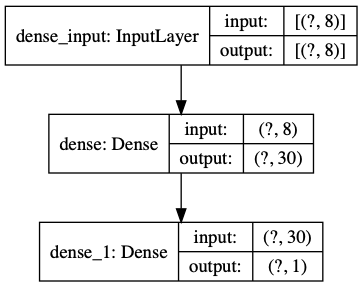

In [196]:
keras.utils.plot_model(model, show_shapes=True)

In [197]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [198]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 90us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5005 - val_l

In [199]:
mse_test = model.evaluate(X_test, y_test, verbose=0)
mse_test

0.4219739536906398

In [200]:
X_new = X_test[:3]
y_pred = model.predict(X_new)
y_pred

array([[0.36892918],
       [1.6819053 ],
       [3.0886497 ]], dtype=float32)

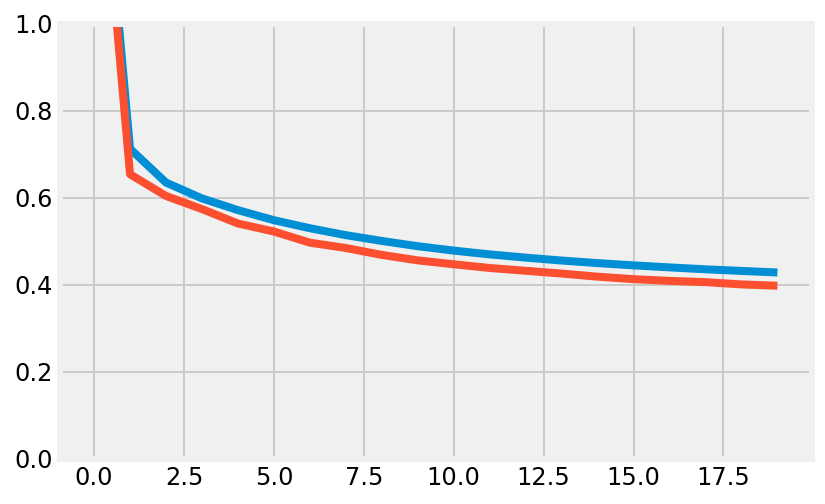

In [201]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [202]:
keras.layers.Input(shape=X_train.shape[1:])

<tf.Tensor 'input_1:0' shape=(None, 8) dtype=float32>

In [203]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Explicit input layer

In [204]:
model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
    ])

In [147]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


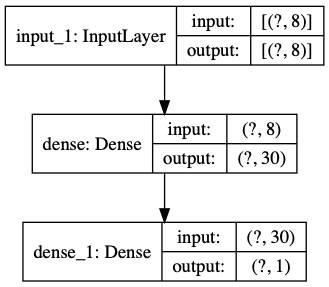

In [205]:
keras.utils.plot_model(model, show_shapes=True)

In [148]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [149]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 57us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5005 - val_l

In [150]:
mse_test = model.evaluate(X_test, y_test, verbose=0)

In [151]:
mse_test

0.4219739536906398